# SkyPulse: Analyzing Air Travel Dynamics for Strategic Insights

### Data Description

In my project, i'm working with 8 tables stored in an SQLite database. Here's a brief overview of each table:

aircrafts_data: This table contains information about aircraft, such as their unique identifiers, the type of aircraft, and the number of seats available. 

airports_data: This table holds data related to airports. It includes details such as airport codes, names, locations, and other relevant information. 

boarding_passes: This table records information about boarding passes issued for flights. It captures details such as the ticket number, seat number, boarding time, and boarding pass ID.

bookings: The bookings table contains data regarding flight bookings made by passengers. It likely includes details such as booking IDs, passenger information, and flight details. 

flights: This table records information about flights, including details such as flight numbers, departure times, arrival times, origins, destinations, and other flight-related data.

seats: The seats table contains data regarding seating arrangements on flights. It likely includes details such as seat numbers, seat types, and availability. 

ticket_flights: This table establishes the relationship between tickets and flights. It likely contains details such as ticket numbers, corresponding flight numbers, and other relevant information. 

tickets: The tickets table contains data related to individual tickets purchased by passengers. It may include details such as ticket numbers, passenger information, and fare details. 

![Airlines Database Structure](airlines.drawio.png)

First, let's bring in the libraries I need.

In [1]:
# Data extraction (SQLite)
import sqlite3  
import json

# Data manipulation
import numpy as np  
import pandas as pd  

# Data visualization
import matplotlib.pyplot as plt  
import plotly.express as px   
import seaborn as sns

# Modeling
from scipy.stats import ttest_ind


### Initiating Database Connection

At this stage, I'll set up the connection to the Airlines database to examine its structure. I'll start by establishing a connection, then proceed to investigate the tables contained within the database. 

In [2]:

path = "C:\\Users\\user\\Desktop\\Github Projects for Portfolio\\Airlines Dataset\\archive\\"  
airlines_db = path + 'travel.sqlite'

conn = sqlite3.connect(airlines_db)

all_tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)

print(all_tables)

    type             name         tbl_name  rootpage  \
0  table   aircrafts_data   aircrafts_data         2   
1  table    airports_data    airports_data         3   
2  table  boarding_passes  boarding_passes         4   
3  table         bookings         bookings         5   
4  table          flights          flights         6   
5  table            seats            seats         7   
6  table   ticket_flights   ticket_flights         8   
7  table          tickets          tickets         9   

                                                 sql  
0  CREATE TABLE aircrafts_data (\r\n    aircraft_...  
1  CREATE TABLE airports_data (\r\n    airport_co...  
2  CREATE TABLE boarding_passes (\r\n    ticket_n...  
3  CREATE TABLE bookings (\r\n    book_ref charac...  
4  CREATE TABLE flights (\r\n    flight_id intege...  
5  CREATE TABLE seats (\r\n    aircraft_code char...  
6  CREATE TABLE ticket_flights (\r\n    ticket_no...  
7  CREATE TABLE tickets (\r\n    ticket_no charac...  


### Load data from the database 'conn' into DataFrames

I'm creating separate Pandas DataFrames to store the data retrieved from each table in the airline database. Each DataFrame corresponds to a specific table and holds all the rows and columns of data from that table.

In [3]:

aircrafts = pd.read_sql("""SELECT *
                                FROM aircrafts_data;""", conn)

airports = pd.read_sql("""SELECT *
                                FROM airports_data;""", conn)

boarding_passes = pd.read_sql("""SELECT *
                        FROM boarding_passes;""", conn)

bookings = pd.read_sql("""SELECT *
                        FROM bookings;""", conn)

flights = pd.read_sql("""SELECT *
                        FROM flights;""", conn)
seats = pd.read_sql("""SELECT *
                        FROM seats;""", conn)
ticket_flights = pd.read_sql("""SELECT *
                        FROM ticket_flights;""", conn)

tickets = pd.read_sql("""SELECT *
                        FROM tickets;""", conn)


### Data Transformation

This dataset is based on airlines information of Russian airports.

Certain columns store information in JSON format, containing descriptions in both English and Russian. 

To streamline my analysis and focus on English-language data, I created a function that extracts only the English names from these JSON columns. 

By doing so, I ensure that the analysis primarily considers English-language information, which is essential for consistency and clarity.

In [4]:
# Function to extract english names from JSON columns
def extract_en_names(row, columns):
    """
    Extracts english names from columns containing JSON-encoded data.

    Args:
        row (pandas.Series): A row of data from the DataFrame.
        columns (list): List of column names to extract names from.

    Returns:
        pandas.Series: Series containing extracted names.

    """
    result = {}
    for column in columns:
        names = json.loads(row[column])
        result[column + '_en'] = names['en']
    return pd.Series(result)


# Columns to apply the function extract_en_names
extract_aircraft = ['model']
extract_airports = ['airport_name', 'city']

# Applying the extract_en_names function to database aircrat and airports
aircrafts = aircrafts.join(aircrafts.apply(lambda row: extract_en_names(row, extract_aircraft), axis=1))
airports = airports.join(airports.apply(lambda row: extract_en_names(row, extract_airports), axis=1))

# Removing the original json columns
aircrafts.drop(columns=extract_aircraft, inplace=True)
airports.drop(columns=extract_airports, inplace=True)


## Data Exploration

Let's take a look at the arilines data, and check if there are missing data and duplicate values.

In [5]:
# List of DataFrames of airlines
airlines_df = [aircrafts, airports, boarding_passes, bookings, flights, seats, ticket_flights, tickets]

# Define a function to inspect each Dataframe
def inspect_data(df):
    """
    Generate a summary of the DataFrame including:
    - Number of rows
    - Number of columns
    - Total number of missing values
    - Total number of duplicate rows
    - Information about the DataFrame (data types, non-null counts, memory usage)
    """
    summary = {
        'rows': df.shape[0],                        # Number of rows in the DataFrame
        'columns': df.shape[1],                     # Number of columns in the DataFrame
        'missing_values': df.isnull().sum().sum(),  # Total number of missing values in the DataFrame
        'duplicates': df.duplicated().sum(),        # Total number of duplicate rows in the DataFrame
        'info': df.info(),                          # DataFrame information (prints to console)
    }
    return summary

# Loop through each DataFrame in the list to inspect its content and structure
for table in airlines_df:
    # Print the name of the table by matching the DataFrame object with its variable name
    print("Table:", [name for name, obj in globals().items() if obj is table][0])
    
    # Print the summary of the DataFrame
    print(inspect_data(table))


Table: aircrafts
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   aircraft_code  9 non-null      object
 1   range          9 non-null      int64 
 2   model_en       9 non-null      object
dtypes: int64(1), object(2)
memory usage: 348.0+ bytes
{'rows': 9, 'columns': 3, 'missing_values': 0, 'duplicates': 0, 'info': None}
Table: airports
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airport_code     104 non-null    object
 1   coordinates      104 non-null    object
 2   timezone         104 non-null    object
 3   airport_name_en  104 non-null    object
 4   city_en          104 non-null    object
dtypes: object(5)
memory usage: 4.2+ KB
{'rows': 104, 'columns': 5, 'missing_values': 0, 'duplicates

Onservations: 
All dataframes are clean, with no missing values or duplicate rows. This indicates high data quality, making it ready for further analysis or processing without the need for additional cleaning steps.

## Question 1: Demand for routes - What is the most popular route based on the number of bookings? And the least popular route?

### 1.1 Merge Dataframes

As indicated by the database structure diagram, the 'boarding passes' dataframe captures individual instances of passengers boarding flights. 

To establish a direct connection between each boarding pass and its corresponding flight, I will merge the boarding passes data with the flights data. This merge enables us to link specific flight details (such as departure time, arrival time, and flight number) to each boarding pass to determine the route.

In [6]:
# Merge boarding_passes DataFrame with flights DataFrame based on variable 'flight_id'
boarding_flights = pd.merge(boarding_passes, flights, how='inner', on='flight_id')

# Merge the result with 'airports' DataFrame to get departure airport information
boarding_flights_airport = pd.merge(boarding_flights, airports, how='inner', left_on='departure_airport', right_on='airport_code')

# Merge the result again with airports DataFrame to get arrival airport information
boarding_flights_airport = pd.merge(boarding_flights_airport, airports, how='inner', left_on='arrival_airport', right_on='airport_code')


### 1.2  Understand my Data

In [7]:
# The data types of dataframe 'boarding_flights_airport' for all columns
print(inspect_data(boarding_flights_airport))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579686 entries, 0 to 579685
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ticket_no            579686 non-null  object
 1   flight_id            579686 non-null  int64 
 2   boarding_no          579686 non-null  int64 
 3   seat_no              579686 non-null  object
 4   flight_no            579686 non-null  object
 5   scheduled_departure  579686 non-null  object
 6   scheduled_arrival    579686 non-null  object
 7   departure_airport    579686 non-null  object
 8   arrival_airport      579686 non-null  object
 9   status               579686 non-null  object
 10  aircraft_code        579686 non-null  object
 11  actual_departure     579686 non-null  object
 12  actual_arrival       579686 non-null  object
 13  airport_code_x       579686 non-null  object
 14  coordinates_x        579686 non-null  object
 15  timezone_x           579686 non-nu

In [8]:
# Convert the 'scheduled_arrival' column to datetime format
boarding_flights_airport['date_arrival'] = pd.to_datetime(boarding_flights_airport['scheduled_arrival'])

# Extract the day, month, and year from the 'date' column
boarding_flights_airport['day_arrival'] = boarding_flights_airport['date_arrival'].dt.day
boarding_flights_airport['month_arrival'] = boarding_flights_airport['date_arrival'].dt.month
boarding_flights_airport['year_arrival'] = boarding_flights_airport['date_arrival'].dt.year

# Print the unique years, months and days in the dataset
print('Year:', sorted(boarding_flights_airport['year_arrival'].unique()))
print('Months:', sorted(boarding_flights_airport['month_arrival'].unique()))
print('Days:', sorted(boarding_flights_airport['day_arrival'].unique()))


Year: [2017]
Months: [7, 8]
Days: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


#### Observations:

* The new DataFrame 'boarding_flights_airport' contains 23 columns and 569,686 rows, representing flights.
* There are no missing values or duplicates in the data.
* 21 columns have string data type, while 2 columns are integers.
* The DataFrame contains flight data exclusively from the year 2017, specifically covering the months of July (7) and August (8). It includes information of fligth arrivals for every day within these two months, spanning from July 1st to August 31st. 

### 1.3 Analyze Flight Routes

The 'boarding_flights_airport' dataset contained coordinates for departure and arrival locations in a string format within the columns coordinates_x and coordinates_y, respectively. These coordinates need to be structured as "(longitude, latitude)" for further geospatial analysis, such as mapping flight routes, and analyzing geographic patterns.

In [9]:
# Extracting departure airport coordinates
boarding_flights_airport['latitude_departure'] = boarding_flights_airport['coordinates_x'].apply(lambda x: float(x.split(',')[1][0:-1]))
boarding_flights_airport['longitude_departure'] = boarding_flights_airport['coordinates_x'].apply(lambda x: float(x.split(',')[0][1:]))

# Extracting arrival airport coordinates
boarding_flights_airport['latitude_arrival'] = boarding_flights_airport['coordinates_y'].apply(lambda x: float(x.split(',')[1][0:-1]))
boarding_flights_airport['longitude_arrival'] = boarding_flights_airport['coordinates_y'].apply(lambda x: float(x.split(',')[0][1:]))

### 1.4 Identifying Major Hubs and Spokes 

I will start to identify the primary hubs, which are airports (city) with the highest number of flights, and spokes, which are airports with fewer flights. By understanding the network of flights and the distribution of traffic among airports, I can gain insights into the dynamics of this air travel and the importance of specific airports within the network. 

In [10]:
# Group the 'boarding_flights_airport' DataFrame by departure city and count the number of unique flight IDs for each city
departure_counts = boarding_flights_airport.groupby('city_en_x')['flight_id'].nunique().reset_index()

# Rename the columns for clarity
departure_counts.columns = ['City_of_Departure', 'Nr_of_Flights']

# Print the number of unique departure cities
print('Nr. of unique departure cities:', departure_counts.shape[0], '\n')
print(departure_counts.head(5))


Nr. of unique departure cities: 91 

  City_of_Departure  Nr_of_Flights
0            Abakan             68
1            Anadyr              5
2             Anapa             62
3       Arkhangelsk            120
4         Astrakhan             70


To understand how flights are distributed across cities, i'll visualize the number of flights per city. 

Since the 'boarding_flights_airport dataset has 91 cities, four subplots were create to make it easier to visualize. 

A logarithmic scale was use to better represent the range of flight frequencies across cities.

c:\Users\user\anaconda3\envs\Learning\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


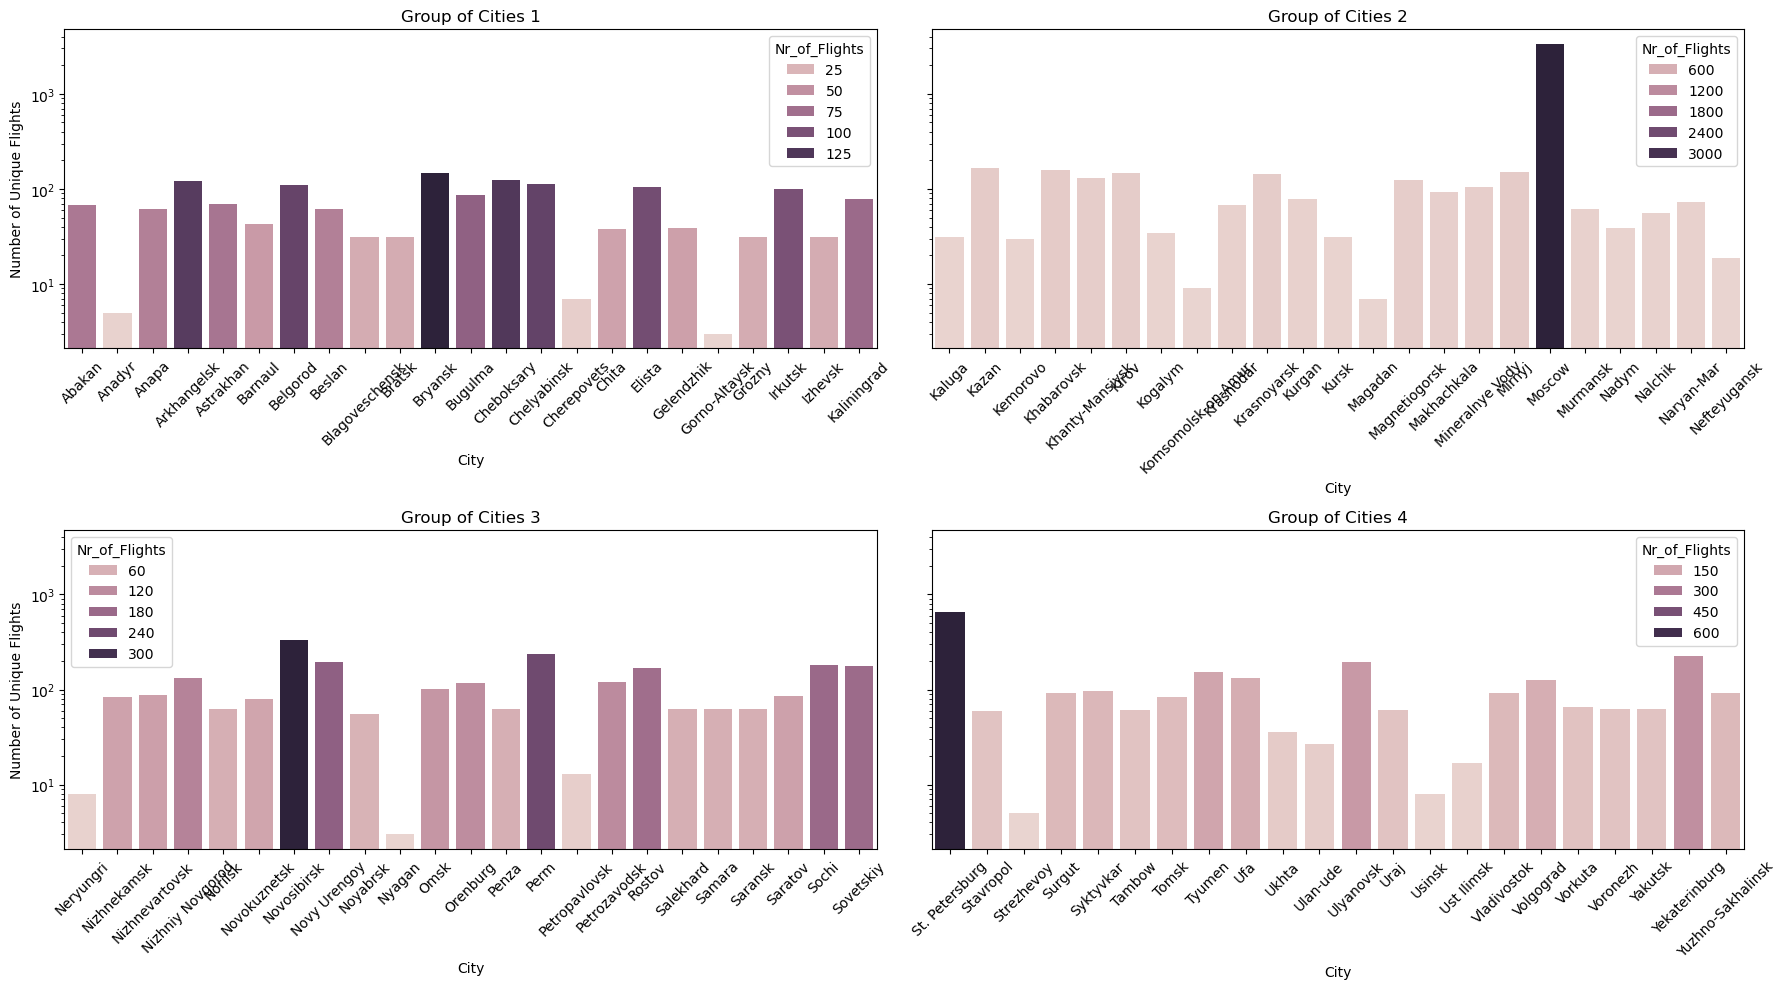

In [11]:
# Defining the number of subplots, rows, and columns
num_subplots, rows, cols = 4, 2, 2

# Split the departure_counts DataFrame into multiple sub-dataframes based on the number of subplots
split_data = np.array_split(departure_counts, num_subplots)

# Create a figure and an array of subplots with the specified number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(18, 10), sharey=True)

# Flatten the array of subplots to iterate over them easily
axes = axes.flatten()

for i in range(num_subplots):
    # Get the current subplot
    ax = axes[i]
    # Plot a bar graph for the current subplot using seaborn
    sns.barplot(x='City_of_Departure', y='Nr_of_Flights', data=split_data[i], ax=ax, hue='Nr_of_Flights')
    ax.set_title(f'Group of Cities {i+1}')
    ax.set_xlabel('City')
    ax.set_ylabel('Number of Unique Flights')
    ax.set_yscale('log')
    ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

plt.tight_layout()   # Adjust the layout of subplots to prevent overlap
plt.show()


Cities with Most Departure Flights (Hubs):
    City_of_Departure  Nr_of_Flights
40            Moscow           3358
69    St. Petersburg            658
52       Novosibirsk            332
59              Perm            239
89     Yekaterinburg            226
53      Novy Urengoy            195
80         Ulyanovsk            193
67             Sochi            180
68         Sovetskiy            176
62            Rostov            169 

Cities with Less Departure Flights (Spokes):
      City_of_Departure  Nr_of_Flights
18       Gorno-Altaysk              3
55              Nyagan              3
1               Anadyr              5
71          Strezhevoy              5
14         Cherepovets              7
35             Magadan              7
46           Neryungri              8
82              Usinsk              8
30  Komsomolsk-on-Amur              9
60       Petropavlovsk             13


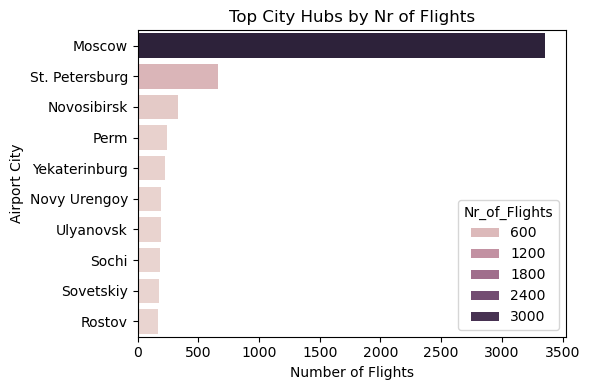

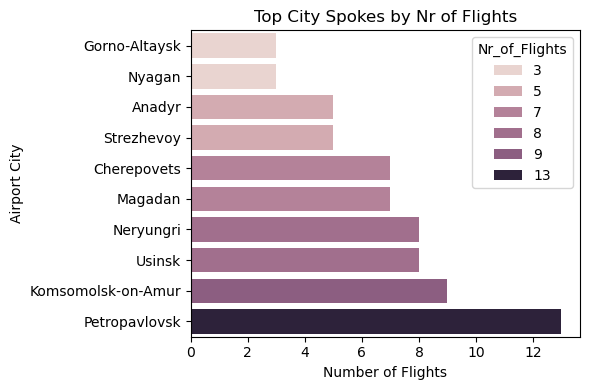

In [12]:
# Defining the number of top cities 
top = 10

# Sort the departure_counts DataFrame by the number of flights in descending order to get top hubs
hubs = departure_counts.sort_values(by='Nr_of_Flights', ascending=False).head(top)

# Sort the departure_counts DataFrame by the number of flights in ascending order to get top spokes
spokes = departure_counts.sort_values(by='Nr_of_Flights', ascending=True).head(top)

# Print the top hubs and spokes
print('Cities with Most Departure Flights (Hubs):\n', hubs, '\n')
print('Cities with Less Departure Flights (Spokes):\n', spokes)

plt.figure(figsize=(6, 4))
sns.barplot(x='Nr_of_Flights', y='City_of_Departure', hue='Nr_of_Flights', data=hubs)
plt.title('Top City Hubs by Nr of Flights')
plt.xlabel('Number of Flights')
plt.ylabel('Airport City')
plt.legend(title='Nr_of_Flights')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x='Nr_of_Flights', y='City_of_Departure', hue='Nr_of_Flights', data=spokes)
plt.title('Top City Spokes by Nr of Flights')
plt.xlabel('Number of Flights')
plt.ylabel('Airport City')
plt.legend(title='Nr_of_Flights')
plt.tight_layout()
plt.show()



Observations: 
- There are 91 cities with fligth departures.
- The city with the highest number of flights is Moscow, with 3,358 flights. 
- The cities with the fewest flights are Gorno-Altaysk and Nyagan, each with only 3 flights. 

## Question 2: Demand for routes: What is the most popular route based on the number of bookings? And the least popular route?

Let's assume that the number of tickets (variable 'tickets_no') are the number of bookings.

### 2.1 Analysis of Ticket Sales by Route

In [13]:
# Group the data by route and count the number of tickets on each route
route_ticket_counts = boarding_flights_airport.groupby(['departure_airport', 'latitude_departure', 'longitude_departure', 'city_en_x',            
                                                        'arrival_airport','latitude_arrival','longitude_arrival','city_en_y']).size().reset_index(name='num_tickets')


total_tickets_sold = route_ticket_counts['num_tickets'].sum()

# Calculate percentage of tickets sold for each route
route_ticket_counts['percentage'] = (route_ticket_counts['num_tickets'] / total_tickets_sold) * 100

# Find the route with the highest number of tickets and its percentage
popular_route = route_ticket_counts.loc[route_ticket_counts['num_tickets'].idxmax()]
popular_route_percentage = "{:.4f}".format(popular_route['percentage'])

# Find the route with the least number of tickets and its percentage
unpopular_route = route_ticket_counts.loc[route_ticket_counts['num_tickets'].idxmin()]
unpopular_route_percentage = "{:.4f}".format(unpopular_route['percentage'])

print("The most popular route is:", popular_route['departure_airport'] + '-' + popular_route['arrival_airport'], '(' + popular_route['city_en_x'] + ' - ' + popular_route['city_en_y'] + ")", popular_route['num_tickets'], "with", "tickets sold, accounting for", popular_route_percentage, "% of total tickets sold.")


print("The least popular route is:", unpopular_route['departure_airport'] + '-' + unpopular_route['arrival_airport'], '(' + unpopular_route['city_en_x'] + ' - ' + unpopular_route['city_en_y'] + ")", "with", unpopular_route['num_tickets'], "tickets sold, accounting for", unpopular_route_percentage, "% of total tickets sold.")



The most popular route is: SVO-LED (Moscow - St. Petersburg) 9757 with tickets sold, accounting for 1.6832 % of total tickets sold.
The least popular route is: CEK-SWT (Chelyabinsk - Strezhevoy) with 8 tickets sold, accounting for 0.0014 % of total tickets sold.


### 2.2 Visualizing Ticket Sales on a Geographical Map

To understand the spatial distribution of ticket sales and identify regions of high demand, I will start to the create an interactive scatter map, using as reference the coordinates of departure airport city.

In [14]:
# Defining the color scale and labels for the scatter map
color_scale = [(0, 'orange'), (1, 'red')]
color_labels = {'num_tickets': 'Tickets Sold'}

# Scatter map using Plotly Express
fig = px.scatter_mapbox(route_ticket_counts,  
                        lat="latitude_departure",  # Latitude values for departure locations
                        lon="longitude_departure",  # Longitude values for departure locations
                        hover_data=['num_tickets'],  
                        color="num_tickets",  
                        color_continuous_scale=color_scale,  
                        size="num_tickets",  # Size of markers based on number of tickets sold
                        zoom=2,  
                        height=1300,  
                        width=900)  

# Update the layout of the map
fig.update_layout(mapbox_style="open-street-map")  # Set the map style to OpenStreetMap
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})  # Set all the margins to 0
fig.update_coloraxes(colorbar_title=color_labels['num_tickets'])  # Set colorbar title
fig.show()


#### Observations:
- The visualization highlights that the majority of departure ticket sales are concentrated near the borders of Europe, particularly around Turkey, and extending towards China. These regions exhibit a higher volume of ticket sales compared to other locations, indicating potentially high travel demand or popularity. 
- Locations further away from these regions tend to have fewer ticket sales, suggesting comparatively lower travel activity or demand. 

### 2.3 Analyze least popular route (CEK-SWT)

In [15]:
# Filter routes that involve Strezhevoy as either departure or arrival city
strezhevoy_routes = route_ticket_counts[(route_ticket_counts['city_en_x'] == 'Strezhevoy') | (route_ticket_counts['city_en_y'] == 'Strezhevoy')]
print('Strezhevoy Routes:', strezhevoy_routes[['departure_airport', 'arrival_airport', 'num_tickets']], '\n')

# Filter routes that involve Chelyabinsk as either departure or arrival city
chelyabinsk_routes = route_ticket_counts[(route_ticket_counts['city_en_x'] == 'Chelyabinsk') | (route_ticket_counts['city_en_y'] == 'Chelyabinsk')]
print('Chelyabinsk Routes:', chelyabinsk_routes[['departure_airport', 'arrival_airport', 'num_tickets']])

# Filter routes that involve Gorno-Altaysk as either departure or arrival city
gorno_routes= route_ticket_counts[(route_ticket_counts['city_en_x'] == 'Gorno-Altaysk') | (route_ticket_counts['city_en_y'] == 'Gorno-Altaysk')]
print('Gorno Routes:', gorno_routes[['departure_airport', 'arrival_airport', 'num_tickets']], '\n')

# Filter routes that involve Nyagan as either departure or arrival city
nyagan_routes = route_ticket_counts[(route_ticket_counts['city_en_x'] == 'Nyagan') | (route_ticket_counts['city_en_y'] == 'Nyagan')]
print('Nyagan Routes:', gorno_routes[['departure_airport', 'arrival_airport', 'num_tickets']], '\n')



Strezhevoy Routes:     departure_airport arrival_airport  num_tickets
39                CEK             SWT            8
367               SWT             CEK            8 

Chelyabinsk Routes:     departure_airport arrival_airport  num_tickets
35                CEK             DME         2108
36                CEK             IKT          214
37                CEK             PEE          655
38                CEK             STW          163
39                CEK             SWT            8
40                CEK             VOG         2115
53                DME             CEK         2298
125               IKT             CEK          250
271               PEE             CEK          869
309               STW             CEK          211
367               SWT             CEK            8
439               VOG             CEK         2211
Gorno Routes:     departure_airport arrival_airport  num_tickets
289               RGK             SVO           35
343               SVO      

#### Observations:

- Strezhevoy airport flight and ticket sales: As seen in 1.4., Strezhevoy airport runs 5 flights but has sold only 16 tickets in total. This significant discrepancy between available flights and tickets sold points to either a lack of demand for flights from Strezhevoy or potential issues in ticket sales strategies. 

- All of Strezhevoy airport’s routes are exclusively connected to Chelyabinsk airport. This may suggest a strategic or operational dependency on Chelyabinsk, making the flight network of Strezhevoy highly specialized and limited to a single destination.

- Chelyabinsk airport flight and booking discrepancy: Although Chelyabinsk Airport operates 23 flights in 12 routes, there are only 8 bookings per flight to Strezhevoyfor . This low booking rate suggests that the flights between Chelyabinsk and Strezhevoy are underutilized, indicating a possible mismatch between flight capacity and passenger demand.

- Even smaller spoke hubs like Nyagan and Gorno-Altaysk, which operate only 3 flights each, have sell 68 tickets. This contrast highlights the particularly low performance of the Strezhevoy route in terms of ticket sales, despite operating more flights.

## Question 3 - Price Variation by Route: 
## How do flight prices vary according to destination and time of month?

In [20]:
# Merge boarding_flights_airport DataFrame with ticket_flights DataFrame based on variable 'ticket_no' to get price of ticket
merge_1 = pd.merge(boarding_flights_airport, ticket_flights, how='inner', on='ticket_no')
merge_2 = pd.merge(merge_1, tickets, how='inner', on='ticket_no')
boarding_flights_airport_amount = pd.merge(merge_2, bookings, how='inner', on='book_ref')
print(boarding_flights_airport_amount.head(5))

       ticket_no  flight_id_x  boarding_no seat_no flight_no  \
0  0005435212351        30625            1      2D    PG0013   
1  0005435212351        30625            1      2D    PG0013   
2  0005435212386        30625            2      3G    PG0013   
3  0005435212386        30625            2      3G    PG0013   
4  0005435212381        30625            3      4H    PG0013   

      scheduled_departure       scheduled_arrival departure_airport  \
0  2017-07-16 18:15:00+03  2017-07-16 20:00:00+03               AER   
1  2017-07-16 18:15:00+03  2017-07-16 20:00:00+03               AER   
2  2017-07-16 18:15:00+03  2017-07-16 20:00:00+03               AER   
3  2017-07-16 18:15:00+03  2017-07-16 20:00:00+03               AER   
4  2017-07-16 18:15:00+03  2017-07-16 20:00:00+03               AER   

  arrival_airport   status  ... longitude_departure latitude_arrival  \
0             SVO  Arrived  ...             39.9566        55.972599   
1             SVO  Arrived  ...             

### 3.1 Daily Price of Popular Route

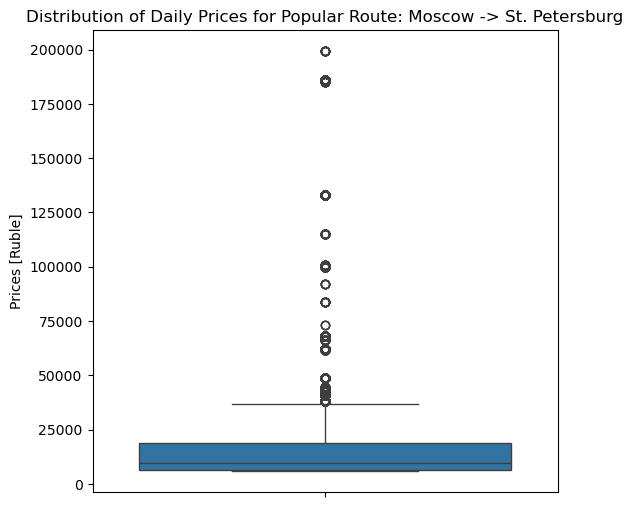

count     66534.000000
mean      21049.185379
std       28412.324929
min        5900.000000
25%        6300.000000
50%        9800.000000
75%       18800.000000
max      199300.000000
Name: amount, dtype: float64


In [21]:
pop_route = boarding_flights_airport_amount[(boarding_flights_airport_amount['city_en_x'] == 'Moscow') & (boarding_flights_airport_amount['city_en_y'] == 'St. Petersburg')]

plt.figure(figsize=(6, 6))
sns.boxplot(data=pop_route,  y='amount')
plt.title('Distribution of Daily Prices for Popular Route: Moscow -> St. Petersburg')
plt.ylabel('Prices [Ruble]')
plt.show()

dist_pop = pop_route['amount'].describe()
print(dist_pop)


Observations:

The significant difference between the mean (21049.19) and the median (9800) and as also observed in the boxplot, there are significant outliers in the price of tickets in this route, especially considering the maximum value of 199300 and the high standard deviation (28412.32).

Given that the mean is significantly higher than the median, this indicates the presence of outliers that are pulling the mean upwards. For that reason, I considered the median a better measure of central tendency for the prices, as it's not affected by outliers and provides a more representative view of the "typical" or "central" price.

Let's visualize the daily median price per day:

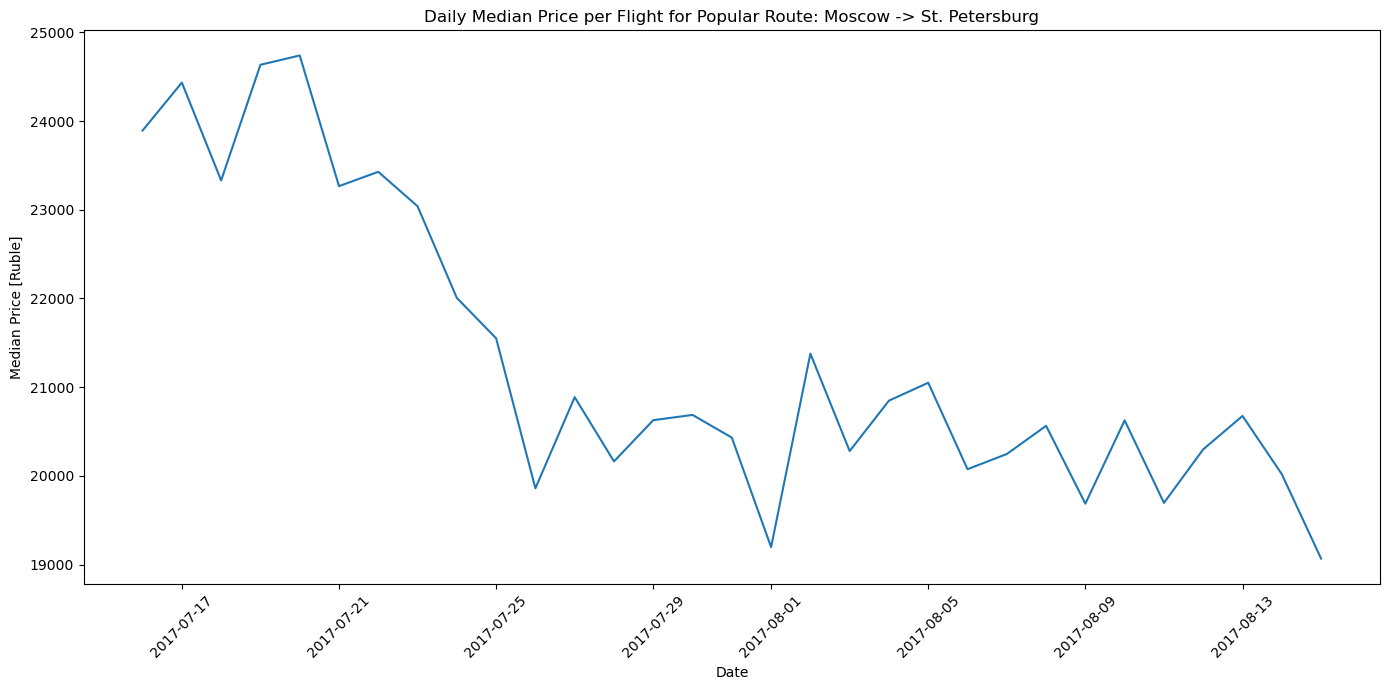

In [22]:
# Calculate the daily median price per flight for the popular route: Moscow -> St. Petersburg
daily_med_price_pop = pop_route.groupby(pop_route['date_arrival'].dt.date)['amount'].mean().reset_index()

daily_med_price_pop.columns = ['date_arrival', 'amount']

# Convert 'date_arrival' column to datetime format
daily_med_price_pop['date_arrival'] = pd.to_datetime(daily_med_price_pop['date_arrival'])

# Plot the line graph
plt.figure(figsize=(14, 7))  
sns.lineplot(data=daily_med_price_pop, x='date_arrival', y='amount')  
plt.title('Daily Median Price per Flight for Popular Route: Moscow -> St. Petersburg')  
plt.xlabel('Date')  
plt.ylabel('Median Price [Ruble]')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show() 


### 3.2 Comparison of median flight prices across different days of the week

C:\Users\user\AppData\Local\Temp\ipykernel_9704\3995493928.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




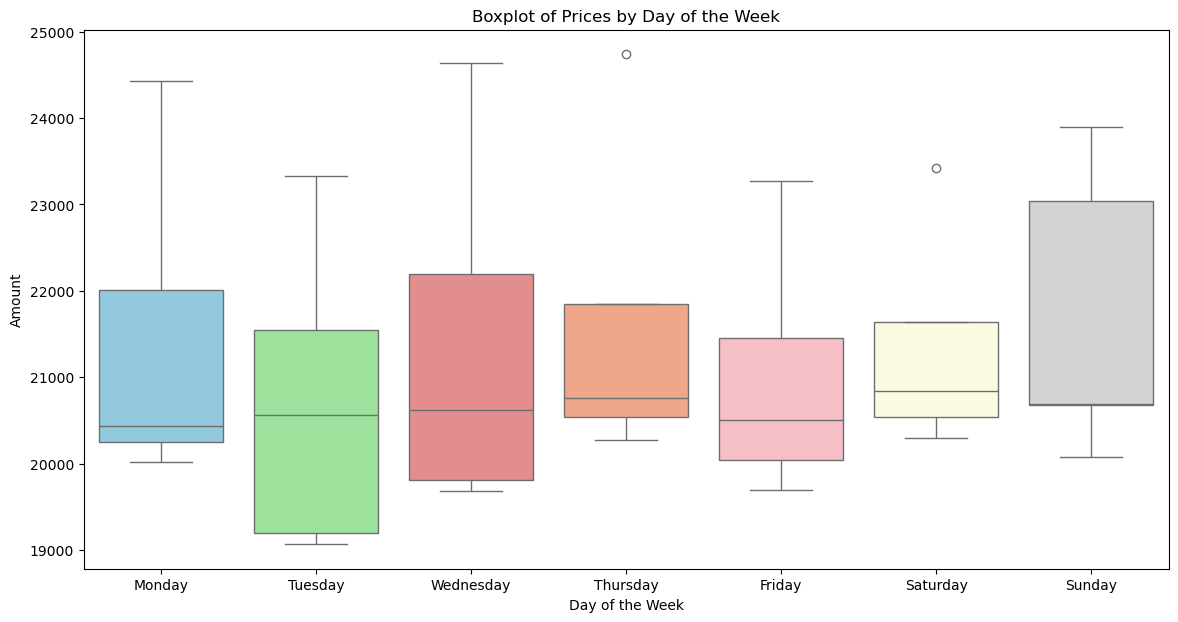

In [23]:
# Adding a new column 'day_of_week' containing the name of the day of the week
daily_med_price_pop['day_of_week'] = daily_med_price_pop['date_arrival'].dt.day_name()

color = {
    'Monday': 'skyblue', 
    'Tuesday': 'lightgreen', 
    'Wednesday': 'lightcoral', 
    'Thursday': 'lightsalmon', 
    'Friday': 'lightpink', 
    'Saturday': 'lightyellow', 
    'Sunday': 'lightgray'
}

# Create a boxplot by day of the week
plt.figure(figsize=(14, 7))  
sns.boxplot(data=daily_med_price_pop, x='day_of_week', y='amount', palette=color, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Boxplot of Prices by Day of the Week')  
plt.xlabel('Day of the Week')  
plt.ylabel('Amount')  
plt.show()  



#### Observations:

* The median of the boxplots for all days of the week is consistent: within a range of 20000-21000 rubles. This suggests that there is no significant difference in prices between different days of the week.

* Mondays tend to have the lowest median price among all days of the week.

* Tuesdays, Wednesdays, and Sundays exhibit the highest dispersion of amount values, as indicated by the longer boxplot. This suggests that prices vary more on these days compared to others.

* Except for Tuesdays, all days exhibit negative skewness of values, indicating that the distribution of prices is skewed towards higher values.

* Tuesday stands out as having the lowest minimum value, suggesting it may be the day of the week with the lowest prices for travel between Moscow and St. Petersburg. However, there is a considerable dispersion of values ranging from 19000 to 23500 rubles on Tuesdays.

* Thursdays and Saturdays have both outliers and lack an upper whisker in their boxplots. However, both days exhibit the lowest dispersion of values, typically around 2000 rubles.


### 3.3 Study the effect of booking time on ticket price of Popular Route

In [52]:
# Converting dates to datetime format
boarding_flights_airport_amount['date_booking'] = pd.to_datetime(boarding_flights_airport_amount['book_date'])

# Calculating the time difference between ticket purchase and flight date
boarding_flights_airport_amount['time_to_flight'] = (boarding_flights_airport_amount['date_arrival'] - boarding_flights_airport_amount['date_booking']).dt.days


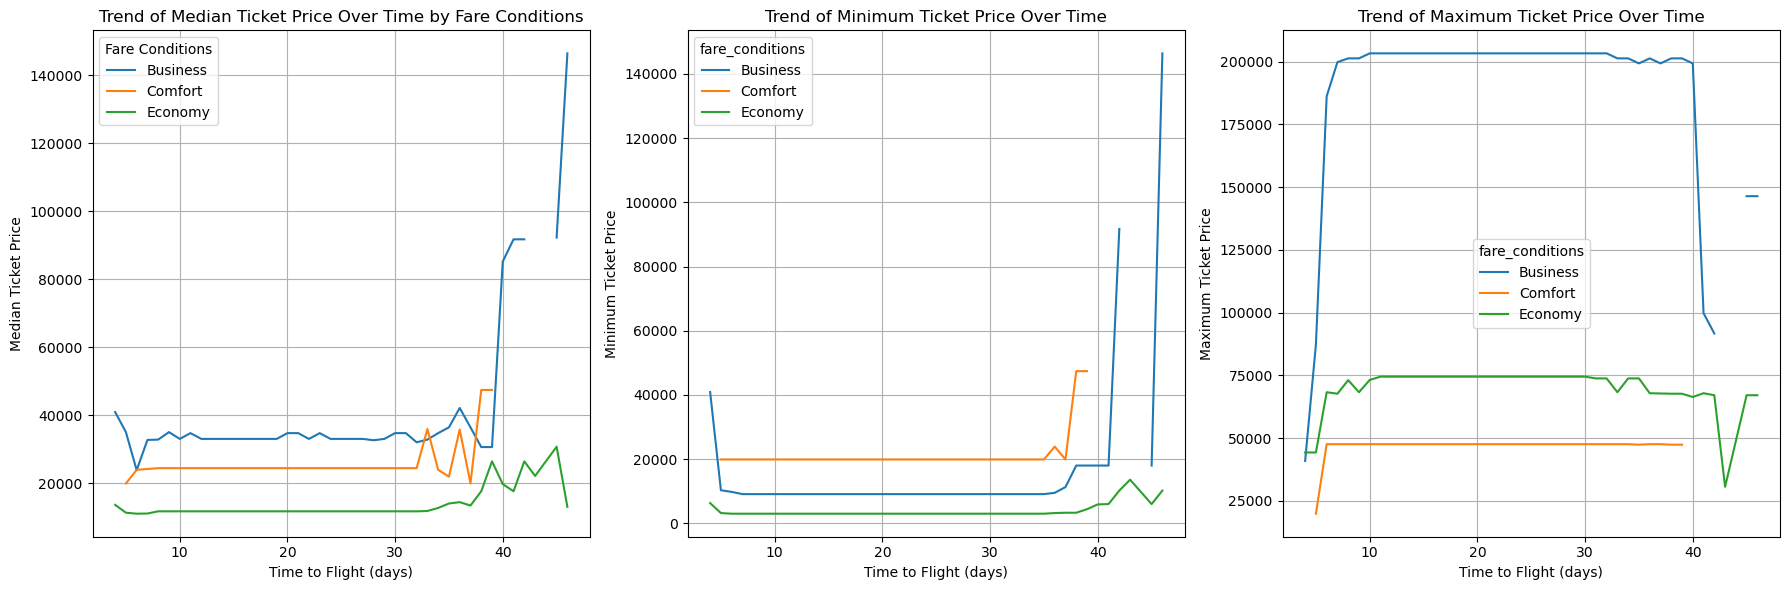

In [60]:

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Median Ticket Price
median_price_by_time = boarding_flights_airport_amount.groupby(['time_to_flight', 'fare_conditions'])['amount'].median().unstack()
median_price_by_time.plot(ax=axs[0])
axs[0].set_xlabel('Time to Flight (days)')
axs[0].set_ylabel('Median Ticket Price')
axs[0].set_title('Trend of Median Ticket Price Over Time by Fare Conditions')
axs[0].grid(True)
axs[0].legend(title='Fare Conditions')

# Minimum Ticket Price
min_price_by_time = boarding_flights_airport_amount.groupby(['time_to_flight', 'fare_conditions'])['amount'].min().unstack()
min_price_by_time.plot(ax=axs[1])
axs[1].set_xlabel('Time to Flight (days)')
axs[1].set_ylabel('Minimum Ticket Price')
axs[1].set_title('Trend of Minimum Ticket Price Over Time')
axs[1].grid(True)

# Maximum Ticket Price
max_price_by_time = boarding_flights_airport_amount.groupby(['time_to_flight', 'fare_conditions'])['amount'].max().unstack()
max_price_by_time.plot(ax=axs[2])
axs[2].set_xlabel('Time to Flight (days)')
axs[2].set_ylabel('Maximum Ticket Price')
axs[2].set_title('Trend of Maximum Ticket Price Over Time')
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [49]:
early_purchase = boarding_flights_airport_amount[boarding_flights_airport_amount['time_to_flight'] <= 30]['amount']
late_purchase = boarding_flights_airport_amount[boarding_flights_airport_amount['time_to_flight'] > 30]['amount']
t_stat, p_value = ttest_ind(early_purchase, late_purchase)

print("Test of t- Student :", t_stat)
print("Student's t-test - p-value:", p_value)

Test of t- Student : -9.684043683275247
Student's t-test - p-value: 3.529072836934607e-22


#### Observations:

* As the Student's t-test compares the means of two groups to determine if there is a statistically significant difference between them. In this case, the very low p-value (3.529072836934607e-22) and the negative t-statistic (-9.68) indicate that there is a significant difference in ticket prices between the groups of bookings made more than 30 days in advance and the groups of bookings made with 30 days or less in advance.

* Based on the results of the Student's t-test, I conclude that there is a statistically significant difference in ticket prices between the two purchase groups, indicating that the time of the booking significantly influences ticket prices. 

* It may be more advantageous in terms of price to buy flight tickets for this route with a lead time of 30 days or more compared to a lead time of less than 30 days.